Processing object 1 for json1:
  ID: campaign--d8d80d6e-58b9-4a25-a93e-f36d47dbde5b
  Type: campaign
  Name: APT BPP
  Node or Edge: node
  File: json1
Processing object 2 for json1:
  ID: intrusion-set--d8d80d6e-58b9-4a25-a93e-f36d47dbde5b
  Type: intrusion-set
  Name: APT BPP
  Node or Edge: node
  File: json1
Processing object 3 for json1:
  ID: identity--c78cb6e5-0c4b-4611-8297-d1b8b55e40b5
  Type: identity
  Name: Franistan
  Node or Edge: node
  File: json1
Processing object 4 for json1:
  ID: identity--9e10cfb8-71df-4823-ba2f-100c70cc29d5
  Type: identity
  Name: Branistan People’s Party
  Node or Edge: node
  File: json1
Processing object 5 for json1:
  ID: identity--39c5b8d9-7b97-41ab-97d7-981b9690a4ec
  Type: identity
  Name: Branistan
  Node or Edge: node
  File: json1
Processing object 6 for json1:
  ID: attack-pattern--b5eaef2b-ec0b-4678-82f4-4f9273179f9e
  Type: attack-pattern
  Name: False Information Insertion
  Node or Edge: node
  File: json1
Processing object 7 for j

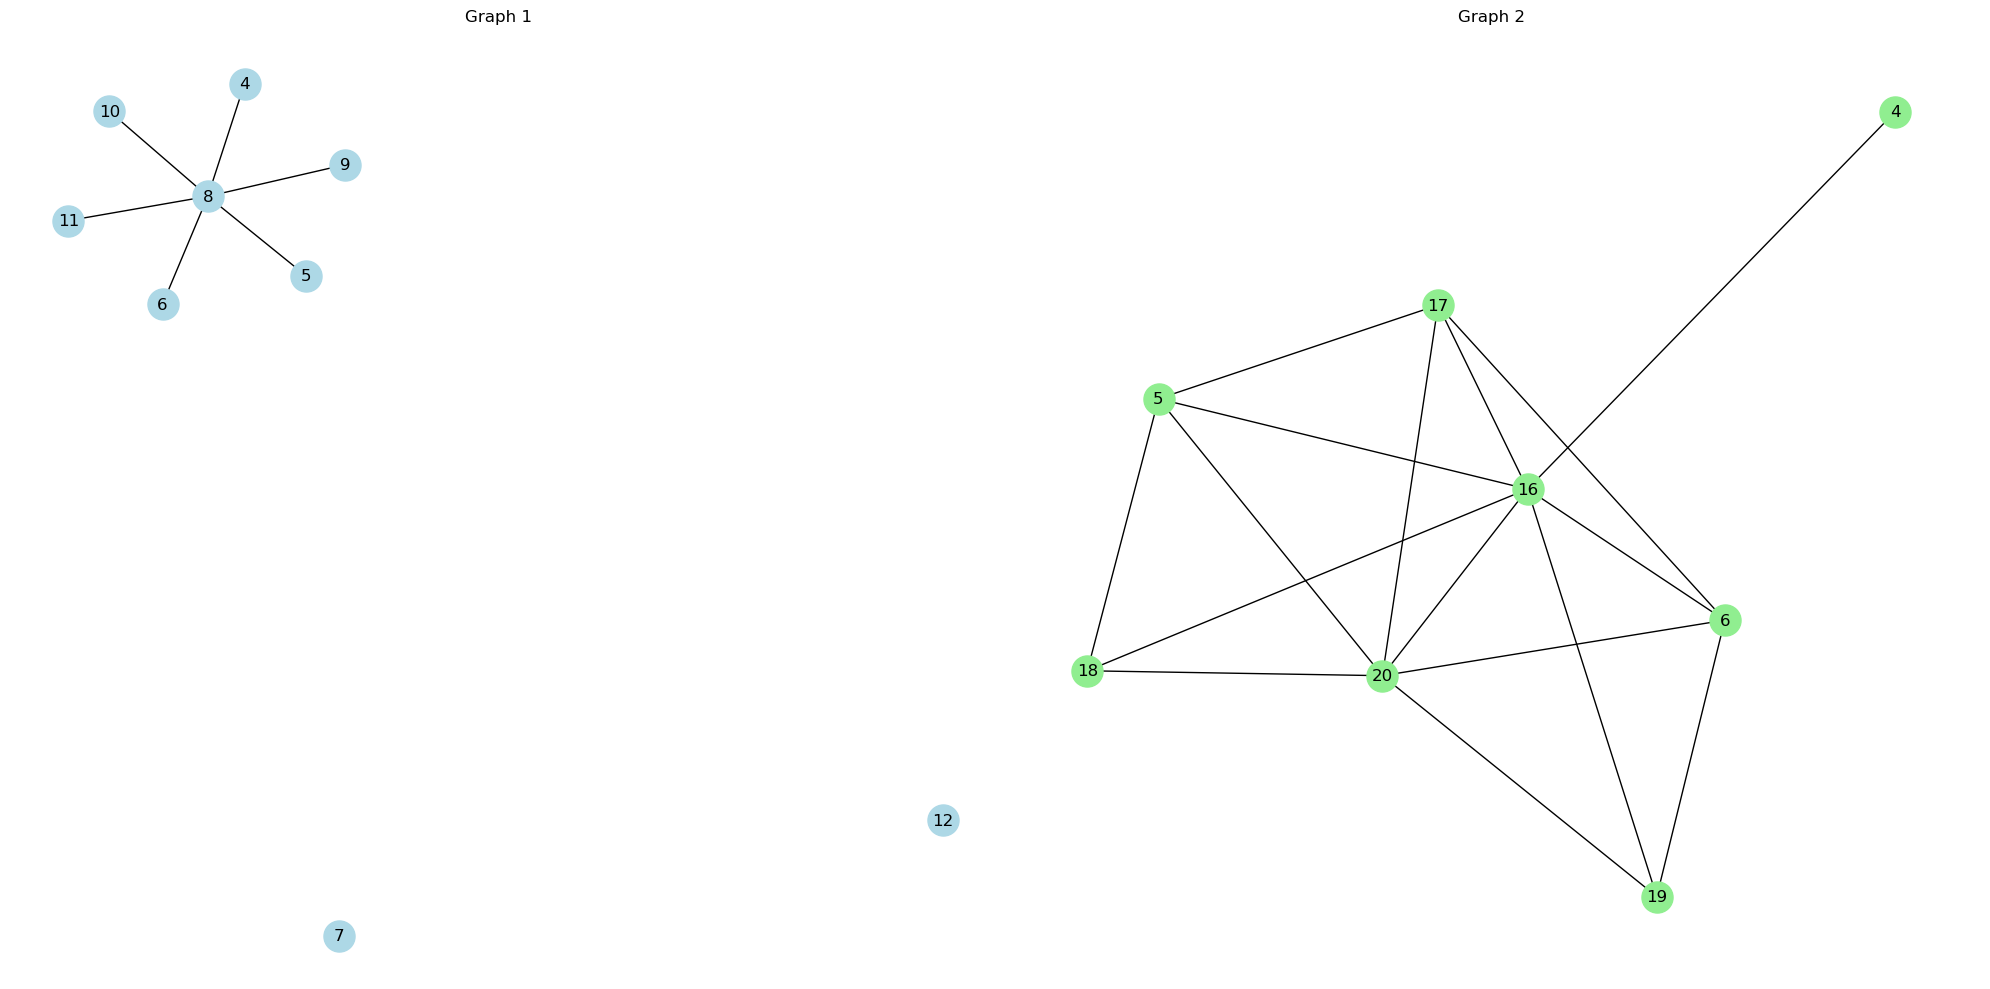

In [4]:
import json
import os
import string
from collections import defaultdict
import heapq
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import torch
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertModel, BertTokenizer

# Constants
OUTPUT_DIR = 'output_files'
THRESHOLD = 0.8

# Load models
nlp = spacy.load("en_core_web_sm")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Utility functions
def create_output_directory():
    os.makedirs(OUTPUT_DIR, exist_ok=True)

def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if isinstance(x, dict):
            for a in x:
                flatten(x[a], name + a + '.')
        elif isinstance(x, list):
            for i, a in enumerate(x):
                flatten(a, name + str(i) + '.')
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

def preprocess_text(text):
    return text.lower().translate(str.maketrans('', '', string.punctuation))

def get_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

# File handling functions
def load_json(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return json.load(file)
    except FileNotFoundError:
        print(f"Error: File not found - {file_path}")
    except json.JSONDecodeError as e:
        print(f"Error: Failed to decode JSON from file - {file_path}")
        print(f"Error details: {e}")
    return None

def save_json(data, file_path):
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)

def save_tokenized_texts_combined(tokenized_texts, file_label):
    with open(os.path.join(OUTPUT_DIR, f"combined_tokenized_output_{file_label}.txt"), "w") as f:
        for tokenized_text in tokenized_texts:
            f.write(" ".join(tokenized_text) + "\n")

def save_embeddings_combined(embeddings, file_label):
    combined_embeddings = np.vstack(embeddings)
    np.save(os.path.join(OUTPUT_DIR, f"combined_embeddings_{file_label}.npy"), combined_embeddings)

# Data processing functions
def json_to_text(data, file_label):
    texts, embeddings, tokenized_texts = [], [], []
    json_objects, original_ids = {}, {}
    object_order = []

    for i, entry in enumerate(data):
        flattened_entry = flatten_json(entry)
        original_id = flattened_entry.pop('id', str(i+1))
        original_ids[original_id] = flattened_entry

        flattened_entry['file'] = file_label
        flattened_entry['node_or_edge'] = 'edge' if 'source_ref' in flattened_entry and 'target_ref' in flattened_entry else 'node'
        
        text = ". ".join(f"{key}: {value}" for key, value in flattened_entry.items())
        text = preprocess_text(text)
        texts.append(text)

        tokenized_text = tokenizer.tokenize(text)
        tokenized_texts.append(tokenized_text)

        embedding = get_embeddings(text)
        embeddings.append(embedding)
        
        json_objects[original_id] = flattened_entry
        object_order.append(original_id)
        
        print(f"Processing object {i+1} for {file_label}:")
        print(f"  ID: {original_id}")
        print(f"  Type: {flattened_entry.get('type', 'No type')}")
        print(f"  Name: {flattened_entry.get('name', 'No name')}")
        print(f"  Node or Edge: {flattened_entry['node_or_edge']}")
        print(f"  File: {flattened_entry['file']}")
    
    print(f"Number of objects in {file_label}: {len(json_objects)}")
    print(f"Number of embeddings in {file_label}: {len(embeddings)}")
    print(f"Object order in {file_label}: {object_order}")
    
    return texts, embeddings, tokenized_texts, json_objects, original_ids, object_order

def assign_encode_ids(texts1, embeddings1, texts2, embeddings2, json_objects1, json_objects2, threshold):
    # 1. Create similarity matrix
    similarity_matrix = cosine_similarity(np.vstack(embeddings1), np.vstack(embeddings2))
    
    # 2. Find best matches for each column (json2 object)
    best_matches = {}
    for j in range(similarity_matrix.shape[1]):
        column = similarity_matrix[:, j]
        above_threshold = np.where(column > threshold)[0]
        if len(above_threshold) > 0:
            best_match = above_threshold[np.argmax(column[above_threshold])]
            best_matches[j] = (best_match, column[best_match])
    
    # 3. Resolve conflicts (same json1 object matching to multiple json2 objects)
    final_matches = {}
    for j, (i, sim) in sorted(best_matches.items(), key=lambda x: -x[1][1]):
        if i not in final_matches.values():
            final_matches[j] = i
    
    # 4. Assign encodeIDs based on the matching
    encode_id = 1
    keys1 = list(json_objects1.keys())
    keys2 = list(json_objects2.keys())
    
    for j, i in final_matches.items():
        json_objects1[keys1[i]]['encodeID'] = encode_id
        json_objects2[keys2[j]]['encodeID'] = encode_id
        encode_id += 1
    
    # 5. Assign encodeIDs to unmatched objects
    for i, key in enumerate(keys1):
        if 'encodeID' not in json_objects1[key]:
            json_objects1[key]['encodeID'] = encode_id
            encode_id += 1
    
    for j, key in enumerate(keys2):
        if 'encodeID' not in json_objects2[key]:
            json_objects2[key]['encodeID'] = encode_id
            encode_id += 1
    
    # 6. Update edge references
    id_to_encodeID = {k: v['encodeID'] for k, v in {**json_objects1, **json_objects2}.items()}
    
    for obj in json_objects1.values():
        if obj.get('node_or_edge') == 'edge':
            obj['source_ref'] = id_to_encodeID.get(obj.get('source_ref'), obj.get('source_ref'))
            obj['target_ref'] = id_to_encodeID.get(obj.get('target_ref'), obj.get('target_ref'))
    
    for obj in json_objects2.values():
        if obj.get('node_or_edge') == 'edge':
            obj['source_ref'] = id_to_encodeID.get(obj.get('source_ref'), obj.get('source_ref'))
            obj['target_ref'] = id_to_encodeID.get(obj.get('target_ref'), obj.get('target_ref'))
    
    return json_objects1, json_objects2, similarity_matrix

def create_matching_report(json_objects1, json_objects2):
    matched = []
    unmatched_1 = []
    unmatched_2 = []

    encode_ids1 = {obj['encodeID'] for obj in json_objects1.values()}
    encode_ids2 = {obj['encodeID'] for obj in json_objects2.values()}

    matched = encode_ids1.intersection(encode_ids2)
    unmatched_1 = encode_ids1 - encode_ids2
    unmatched_2 = encode_ids2 - encode_ids1

    return matched, unmatched_1, unmatched_2

# Helper function to print matches
def print_matches(json_objects1, json_objects2):
    matches = {}
    for k1, v1 in json_objects1.items():
        for k2, v2 in json_objects2.items():
            if v1['encodeID'] == v2['encodeID']:
                matches[v1['encodeID']] = (v1, v2)
    
    for encode_id, (obj1, obj2) in matches.items():
        print(f"Match for encodeID {encode_id}:")
        print(f"  json1: {obj1.get('type', 'No type')} - {obj1.get('name', 'No name')}")
        print(f"  json2: {obj2.get('type', 'No type')} - {obj2.get('name', 'No name')}")
        print()

def identify_node_or_edge_and_add_key(json_objects):
    encode_ids = set()
    for entry in json_objects.values():
        if 'encodeID' in entry:
            encode_ids.add(entry['encodeID'])
        else:
            print(f"Warning: 'encodeID' missing from object: {entry}")
    
    for obj in json_objects.values():
        if 'encodeID' not in obj:
            obj['encodeID'] = max(encode_ids) + 1 if encode_ids else 1
            encode_ids.add(obj['encodeID'])
        
        obj.pop('original_number', None)
        
        values = set(obj.values())
        obj['node_or_edge'] = "edge" if len(values.intersection(encode_ids)) >= 2 else "node"
    
    return json_objects

# Graph functions
def build_graphs(json_objects1, json_objects2):
    G1 = nx.Graph()
    G2 = nx.Graph()

    # Build G1
    for obj in json_objects1.values():
        if obj['node_or_edge'] != 'edge':
            G1.add_node(obj['encodeID'], description=obj.get('description', 'No description provided'))

    for obj in json_objects1.values():
        if obj['node_or_edge'] == 'edge':
            source = obj.get('source_ref')
            target = obj.get('target_ref')
            if source in G1.nodes and target in G1.nodes and source != target:
                G1.add_edge(source, target)

    # Build G2
    for obj in json_objects2.values():
        if obj['node_or_edge'] != 'edge':
            G2.add_node(obj['encodeID'], description=obj.get('description', 'No description provided'))

    for obj in json_objects2.values():
        if obj['node_or_edge'] == 'edge':
            source = obj.get('source_ref')
            target = obj.get('target_ref')
            if source in G2.nodes and target in G2.nodes and source != target:
                G2.add_edge(source, target)

    return G1, G2

def calculate_graph_edit_distance(G1, G2):
    def node_match(n1, n2):
        return n1 == n2

    def edge_match(e1, e2):
        return e1 == e2

    ged = nx.graph_edit_distance(
        G1, G2,
        node_match=node_match,
        edge_match=edge_match,
        node_subst_cost=lambda n1, n2: 0 if node_match(n1, n2) else 1,
        node_del_cost=lambda n: 1,
        node_ins_cost=lambda n: 1,
        edge_subst_cost=lambda e1, e2: 0 if edge_match(e1, e2) else 1,
        edge_del_cost=lambda e: 1,
        edge_ins_cost=lambda e: 1
    )

    nodes_G1 = set(G1.nodes())
    nodes_G2 = set(G2.nodes())
    edges_G1 = set(G1.edges())
    edges_G2 = set(G2.edges())

    inserted_nodes = nodes_G2 - nodes_G1
    deleted_nodes = nodes_G1 - nodes_G2
    substituted_nodes = nodes_G1 & nodes_G2

    inserted_edges = edges_G2 - edges_G1
    deleted_edges = edges_G1 - edges_G2
    substituted_edges = edges_G1 & edges_G2

    # Calculate costs
    node_insertion_cost = len(inserted_nodes)
    node_deletion_cost = len(deleted_nodes)
    node_substitution_cost = 0  # Assuming no cost if IDs are the same

    edge_insertion_cost = len(inserted_edges)
    edge_deletion_cost = len(deleted_edges)
    edge_substitution_cost = 0  # Assuming no cost if edges are the same

    total_node_cost = node_insertion_cost + node_deletion_cost + node_substitution_cost
    total_edge_cost = edge_insertion_cost + edge_deletion_cost + edge_substitution_cost
    total_cost = total_node_cost + total_edge_cost

    return (ged, inserted_nodes, deleted_nodes, substituted_nodes, 
            inserted_edges, deleted_edges, substituted_edges,
            node_insertion_cost, node_deletion_cost, node_substitution_cost,
            edge_insertion_cost, edge_deletion_cost, edge_substitution_cost,
            total_node_cost, total_edge_cost, total_cost)

def visualize_graphs(G1, G2):
    plt.figure(figsize=(20, 10))

    plt.subplot(121)
    nx.draw(G1, with_labels=True, node_color='lightblue', node_size=500, font_size=12)
    plt.title("Graph 1")

    plt.subplot(122)
    nx.draw(G2, with_labels=True, node_color='lightgreen', node_size=500, font_size=12)
    plt.title("Graph 2")

    plt.tight_layout()
    plt.show()

def get_optimal_figsize(num_nodes):
    base_size = 10
    scale_factor = 0.5
    return (base_size + num_nodes * scale_factor, base_size + num_nodes * scale_factor)

def get_optimal_k(num_nodes):
    base_k = 0.5
    scale_factor = 0.1
    return base_k + num_nodes * scale_factor

# Distance calculation functions
def calculate_distances(json_objects1, json_objects2):
    def set_distance(set1, set2):
        return abs(len(set1) - len(set2))

    nodes1 = set(json_objects1.keys())
    nodes2 = set(json_objects2.keys())
    node_distance = set_distance(nodes1, nodes2)

    keys1 = set(k for obj in json_objects1.values() for k in obj.keys())
    keys2 = set(k for obj in json_objects2.values() for k in obj.keys())
    key_distance = set_distance(keys1, keys2)

    values1 = set(v for obj in json_objects1.values() for v in obj.values() if isinstance(v, str))
    values2 = set(v for obj in json_objects2.values() for v in obj.values() if isinstance(v, str))
    value_distance = set_distance(values1, values2)

    G1, G2 = build_graphs(json_objects1, json_objects2)
    graph_distance = nx.graph_edit_distance(G1, G2, node_subst_cost=lambda n1, n2: 0 if n1 == n2 else 1,
                                            edge_subst_cost=lambda e1, e2: 0 if e1 == e2 else 1)

    print(f"Node Distance (Simple): {node_distance}")
    print(f"Key Distance (Simple): {key_distance}")
    print(f"Value Distance (Simple): {value_distance}")
    print(f"Graph Distance: {graph_distance:.2f}")

def calculate_detailed_distances(json_objects1, json_objects2, threshold):
    def compare_keys(obj1, obj2):
        keys1 = set(obj1.keys()) - {'file', 'node_or_edge', 'encodeID'}
        keys2 = set(obj2.keys()) - {'file', 'node_or_edge', 'encodeID'}
        
        common_keys = keys1.intersection(keys2)
        only_in_1 = keys1 - keys2
        only_in_2 = keys2 - keys1
        
        substitutions = sum(1 for k in common_keys if obj1[k] != obj2[k])
        deletions = len(only_in_1)
        insertions = len(only_in_2)
        
        return substitutions, deletions, insertions

    node_i, node_d, node_s = 0, 0, 0
    edge_i, edge_d, edge_s = 0, 0, 0
    key_i, key_d, key_s = 0, 0, 0
    value_s = 0

    nodes1 = {k: v for k, v in json_objects1.items() if v['node_or_edge'] == 'node'}
    nodes2 = {k: v for k, v in json_objects2.items() if v['node_or_edge'] == 'node'}
    edges1 = {k: v for k, v in json_objects1.items() if v['node_or_edge'] == 'edge'}
    edges2 = {k: v for k, v in json_objects2.items() if v['node_or_edge'] == 'edge'}

    print("Nodes in JSON1:", list(nodes1.keys()))
    print("Nodes in JSON2:", list(nodes2.keys()))
    print("Edges in JSON1:", list(edges1.keys()))
    print("Edges in JSON2:", list(edges2.keys()))

    common_nodes = set(nodes1.keys()) & set(nodes2.keys())
    node_s = len(common_nodes)
    node_d = len(nodes1) - node_s
    node_i = len(nodes2) - node_s

    print(f"Node substitutions: {node_s}")
    print(f"Node deletions: {node_d}")
    print(f"Node insertions: {node_i}")

    common_edges = set(edges1.keys()) & set(edges2.keys())
    edge_s = len(common_edges)
    edge_d = len(edges1) - edge_s
    edge_i = len(edges2) - edge_s

    print(f"Edge substitutions: {edge_s}")
    print(f"Edge deletions: {edge_d}")
    print(f"Edge insertions: {edge_i}")

    for node_id in common_nodes:
        obj1, obj2 = nodes1[node_id], nodes2[node_id]
        key_sub, key_del, key_ins = compare_keys(obj1, obj2)
        key_s += key_sub
        key_d += key_del
        key_i += key_ins
        
        common_keys = set(obj1.keys()) & set(obj2.keys()) - {'file', 'node_or_edge', 'encodeID'}
        value_s += sum(1 for k in common_keys if obj1[k] != obj2[k])

    print(f"Key substitutions: {key_s}")
    print(f"Key deletions: {key_d}")
    print(f"Key insertions: {key_i}")
    print(f"Value substitutions: {value_s}")

    node_distance = node_i + node_d + node_s
    edge_distance = edge_i + edge_d + edge_s
    key_distance = key_i + key_d + key_s
    value_distance = value_s

    return [{
        "node_distance": node_distance,
        "node_i": node_i,
        "node_d": node_d,
        "node_s": node_s,
        "edge_distance": edge_distance,
        "edge_i": edge_i,
        "edge_d": edge_d,
        "edge_s": edge_s,
        "key_distance": key_distance,
        "key_i": key_i,
        "key_d": key_d,
        "key_s": key_s,
        "value_distance": value_distance,
        "value_s": value_s
    }]

def output_networkx_style(G1, G2):
    def node_match(n1, n2):
        return n1.get('type') == n2.get('type') and n1.get('name') == n2.get('name')

    def edge_match(e1, e2):
        return e1.get('relationship_type') == e2.get('relationship_type')

    ged = nx.graph_edit_distance(
        G1, G2,
        node_match=node_match,
        edge_match=edge_match,
        node_subst_cost=lambda n1, n2: 0.5 if node_match(n1, n2) else 1,
        node_del_cost=lambda n: 1,
        node_ins_cost=lambda n: 1,
        edge_subst_cost=lambda e1, e2: 0.5 if edge_match(e1, e2) else 1,
        edge_del_cost=lambda e: 1,
        edge_ins_cost=lambda e: 1
    )
    
    inserted_nodes = set(G2.nodes()) - set(G1.nodes())
    deleted_nodes = set(G1.nodes()) - set(G2.nodes())
    substituted_nodes = {(n1, n2) for n1 in G1.nodes() for n2 in G2.nodes() if node_match(G1.nodes[n1], G2.nodes[n2])}
    
    inserted_edges = set(G2.edges()) - set(G1.edges())
    deleted_edges = set(G1.edges()) - set(G2.edges())
    substituted_edges = {(e1, e2) for e1 in G1.edges() for e2 in G2.edges() if edge_match(G1.edges[e1], G2.edges[e2])}
    
    node_insertion_cost = len(inserted_nodes)
    node_deletion_cost = len(deleted_nodes)
    node_substitution_cost = sum(0.5 if node_match(G1.nodes[n1], G2.nodes[n2]) else 1 for n1, n2 in substituted_nodes)
    
    edge_insertion_cost = len(inserted_edges)
    edge_deletion_cost = len(deleted_edges)
    edge_substitution_cost = sum(0.5 if edge_match(G1.edges[e1], G2.edges[e2]) else 1 for e1, e2 in substituted_edges)
    
    total_node_cost = node_insertion_cost + node_deletion_cost + node_substitution_cost
    total_edge_cost = edge_insertion_cost + edge_deletion_cost + edge_substitution_cost
    total_cost = total_node_cost + total_edge_cost

    output = f"""Graph Edit Distance: {ged}
        Inserted Nodes: {inserted_nodes}
        Deleted Nodes: {deleted_nodes}
        Substituted Nodes: {substituted_nodes}
        Inserted Edges: {inserted_edges}
        Deleted Edges: {deleted_edges}
        Substituted Edges: {substituted_edges}
        Costs:
        Node Insertion Cost: {node_insertion_cost}
        Node Deletion Cost: {node_deletion_cost}
        Node Substitution Cost: {node_substitution_cost}
        Edge Insertion Cost: {edge_insertion_cost}
        Edge Deletion Cost: {edge_deletion_cost}
        Edge Substitution Cost: {edge_substitution_cost}
        Total Node Cost: {total_node_cost}
        Total Edge Cost: {total_edge_cost}
        Total Cost: {total_cost}"""

    with open(os.path.join(OUTPUT_DIR, 'networkx_style_output.txt'), 'w') as f:
        f.write(output)

    print("NetworkX style output saved to 'output_files/networkx_style_output.txt'.")

def save_embeddings_to_excel(embeddings1, embeddings2, json_objects1, json_objects2, file_path, threshold):
    aggregated_embeddings1 = np.array([embedding.mean(axis=0) for embedding in embeddings1])
    aggregated_embeddings2 = np.array([embedding.mean(axis=0) for embedding in embeddings2])
    
    similarity_matrix = cosine_similarity(aggregated_embeddings1, aggregated_embeddings2)
    
    labels1 = [f"{obj['encodeID']}" for obj in json_objects1.values()]
    labels2 = [f"{obj['encodeID']}" for obj in json_objects2.values()]
    
    similarity_df = pd.DataFrame(similarity_matrix, index=labels1, columns=labels2)
    
    # Create a DataFrame for the matches based on encodeIDs
    matches = []
    for obj1 in json_objects1.values():
        encode_id = obj1['encodeID']
        obj2 = next((obj for obj in json_objects2.values() if obj['encodeID'] == encode_id), None)
        if obj2:
            similarity = similarity_matrix[labels1.index(str(encode_id)), labels2.index(str(encode_id))]
            matches.append((encode_id, encode_id, similarity))
    
    match_df = pd.DataFrame(matches, columns=['JSON1 encodeID', 'JSON2 encodeID', 'Similarity'])
    
    # Create binary match matrix
    binary_match_matrix = np.zeros_like(similarity_matrix, dtype=int)
    for match in matches:
        i = labels1.index(str(match[0]))
        j = labels2.index(str(match[1]))
        binary_match_matrix[i, j] = 1
    
    binary_match_df = pd.DataFrame(binary_match_matrix, index=labels1, columns=labels2)
    
    with pd.ExcelWriter(os.path.join(OUTPUT_DIR, file_path)) as writer:
        similarity_df.to_excel(writer, sheet_name='Similarity Matrix')
        match_df.to_excel(writer, sheet_name='Matches', index=False)
        binary_match_df.to_excel(writer, sheet_name='Binary Match Matrix')
        
        # Add a new sheet for embeddings
        embeddings_df1 = pd.DataFrame(aggregated_embeddings1, index=labels1)
        embeddings_df2 = pd.DataFrame(aggregated_embeddings2, index=labels2)
        embeddings_df = pd.concat([embeddings_df1, embeddings_df2], axis=1, keys=['JSON1 Embeddings', 'JSON2 Embeddings'])
        embeddings_df.to_excel(writer, sheet_name='Embeddings')

    print(f"Embeddings, similarity matrix, matches, and binary match matrix saved to 'output_files/{file_path}'.")


def main():
    create_output_directory()

    path1 = input("Enter the file path for JSON 1: ").strip('"')
    path2 = input("Enter the file path for JSON 2: ").strip('"')
    threshold = float(input("Enter the similarity threshold (e.g., 0.95): ").strip())

    data1 = load_json(path1)
    data2 = load_json(path2)
    if data1 is None or data2 is None:
        return

    texts1, embeddings1, tokenized_texts1, json_objects1, original_ids1, order1 = json_to_text(data1, 'json1')
    texts2, embeddings2, tokenized_texts2, json_objects2, original_ids2, order2 = json_to_text(data2, 'json2')

    print(f"Number of objects before assign_encode_ids, json_objects1: {len(json_objects1)}, json_objects2: {len(json_objects2)}")

    json_objects1, json_objects2, similarity_matrix = assign_encode_ids(
    texts1, embeddings1, texts2, embeddings2, json_objects1, json_objects2, threshold)

    if not json_objects1:
        print("Error: json_objects1 is empty after processing.")
        return

    json_objects1 = identify_node_or_edge_and_add_key(json_objects1)
    json_objects2 = identify_node_or_edge_and_add_key(json_objects2)

    combined_tokenized_texts = tokenized_texts1 + tokenized_texts2
    save_tokenized_texts_combined(combined_tokenized_texts, 'combined')
    save_embeddings_combined(embeddings1 + embeddings2, 'combined')

    save_json(json_objects1, os.path.join(OUTPUT_DIR, 'normalized_data1.json'))
    save_json(json_objects2, os.path.join(OUTPUT_DIR, 'normalized_data2.json'))    

    # Save embeddings to Excel
    save_embeddings_to_excel(
    embeddings1, embeddings2, json_objects1, json_objects2,
    'embeddings_and_similarity.xlsx', threshold
    )
    print("Embeddings, similarity matrix, and best matches saved to 'output_files/embeddings_and_similarity.xlsx'.")

    G1, G2 = build_graphs(json_objects1, json_objects2)

    (ged, inserted_nodes, deleted_nodes, substituted_nodes, 
     inserted_edges, deleted_edges, substituted_edges,
     node_insertion_cost, node_deletion_cost, node_substitution_cost,
     edge_insertion_cost, edge_deletion_cost, edge_substitution_cost,
     total_node_cost, total_edge_cost, total_cost) = calculate_graph_edit_distance(G1, G2)

    output_networkx_style(G1, G2)

    calculate_distances(json_objects1, json_objects2)

    detailed_distances = calculate_detailed_distances(json_objects1, json_objects2, threshold)
    save_json(detailed_distances, os.path.join(OUTPUT_DIR, 'detailed_distances.json'))
    print("Detailed distances saved to 'output_files/detailed_distances.json'.")

    visualize_graphs(G1, G2)

if __name__ == "__main__":
    main()